# 2D Nuclear Segmentation with Feature Pyramid Networks

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))
MODEL_NAME = "fpnet"
FGBG_MODEL_NAME = MODEL_NAME + "_fgbg"

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [11]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'fpn_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 1
batch_size = 1
test_size = 0.1
norm_method = "std"

# Optimizer settings
# lr = 1e-5
# optimizer = Adam(lr=lr, clipnorm=0.001)
# lr_sched = rate_scheduler(lr=lr, decay=0.99)

lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Augmentation settings
rotation_range = 180
flip = True
shear = False
zoom_range = (0.5, 1.2)
test_zoom = [0.5, 0.8, 1.0, 1.2, 2.0]
nsteps = 500

# n_conv_filters = 32
# n_dense_filters = 128

transform = "watershed"
distance_bins = 4
n_features = distance_bins
erosion_width = 0

### Create model

In [12]:
from deepcell.model_zoo import FPNet

fgbg_model = FPNet(backbone=backbone,
             input_shape=X_train.shape[1:],
             n_classes=2)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:264: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
fgbg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
image_normalization2d (ImageNor (None, 216, 256, 1)  3721        input_1[0][0]                    
__________________________________________________________________________________________________
tensor_product (TensorProduct)  (None, 216, 256, 3)  6           image_normalization2d[0][0]      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 216, 256, 32) 896         tensor_product[0][0]             
__________________________________________________________________________________________________
batch_norm

In [13]:
%%time

from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
   model=fgbg_model,
   dataset=DATA_FILE,
   model_name=FGBG_MODEL_NAME,
   test_size=test_size,
   seed=1984,
   optimizer=optimizer,
   n_epoch=n_epoch,
   batch_size=batch_size,
   transform="fgbg",
   model_dir=MODEL_DIR,
   log_dir=LOG_DIR,
   lr_sched=lr_sched,
   rotation_range=rotation_range,
   flip=flip,
   shear=shear,
   zoom_range=zoom_range)

X_train shape: (6480, 216, 256, 1)
y_train shape: (6480, 216, 256, 1)
X_test shape: (720, 216, 256, 1)
y_test shape: (720, 216, 256, 1)
Output Shape: (None, None, None, 2)
Number of Classes: 2
Training on 2 GPUs
Epoch 1/1
3239/3240 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9626
Epoch 00001: val_loss improved from inf to 0.23524, saving model to /data/models/fpnet_fgbg.h5
3240/3240 [==============================] - 603s 186ms/step - loss: 0.1874 - acc: 0.9626 - val_loss: 0.2352 - val_acc: 0.9612
CPU times: user 19min 56s, sys: 2min 39s, total: 22min 36s
Wall time: 10min 29s


In [14]:
%%time 
test_images_fgbg = fgbg_model.predict(X_test)

print('segmentation mask shape:', test_images_fgbg.shape)

segmentation mask shape: (1440, 216, 256, 2)
CPU times: user 8.21 s, sys: 2.98 s, total: 11.2 s
Wall time: 9.51 s


0.000150246
1.0
8.5348256e-07
0.99999905
0.00017117642
1.0
2.0457897e-05
0.99998486
0.00014501938
0.9999995
5.710265e-06
1.0
5.831234e-05
0.9999999
0.00012127585
0.9992949
0.00019553033
1.0
5.316185e-05
0.9999993


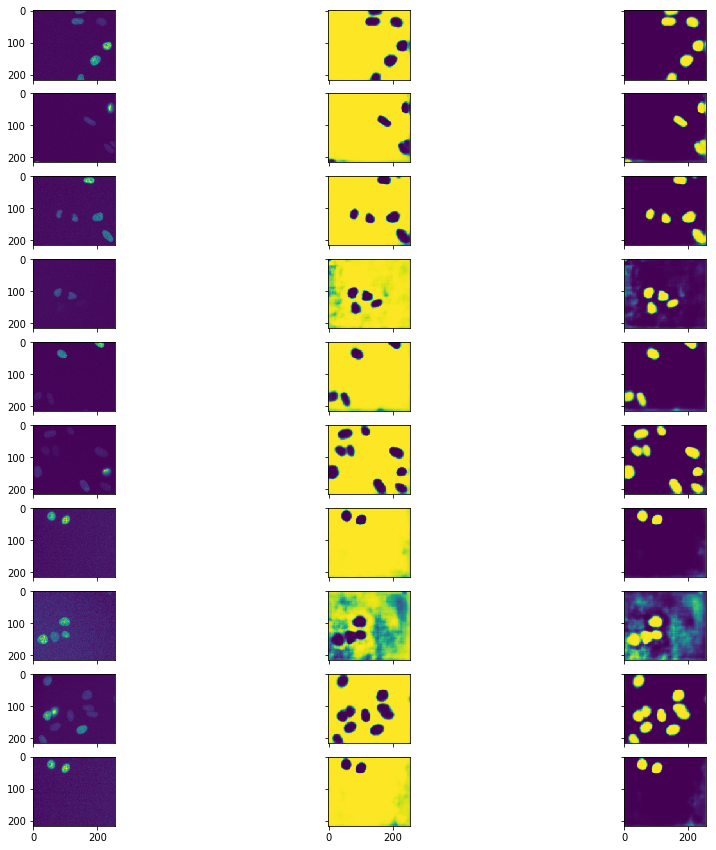

In [15]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(10,3, figsize=(15, 15), sharex=True, sharey=True)
for i in range(10):
    ax[i,0].imshow(X_test[i,:,:,0])
    ax[i,1].imshow(test_images_fgbg[i,:,:,0])
    ax[i,2].imshow(test_images_fgbg[i,:,:,1])
    print(np.amin(test_images_fgbg[i,:,:,0]))
    print(np.amax(test_images_fgbg[i,:,:,0]))